In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

from keras_gpu_callbacks import GPUMetricTrackerCallback

In [2]:
(dataset,), ds_info = tfds.load(
    'bee_dataset/bee_dataset_300',
    split=['train'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

def normalize_img(image, label):
    """Normalizes images: `uint8` -> `float32`.  Stacks label fields into a multi-hot vector."""
    return (
        tf.cast(image, tf.float32) / 255.,
        tf.stack([label['cooling_output'], label['pollen_output'], label['varroa_output'], label['wasps_output']])
    )

dataset = dataset.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE).cache()
mnist_train = dataset.shuffle(ds_info.splits['train'].num_examples)
dataset = dataset.batch(128)
dataset = dataset.prefetch(tf.data.AUTOTUNE)

Label: [0. 0. 0. 1.]


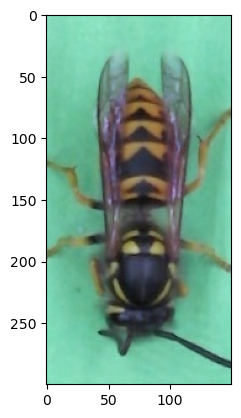

In [3]:
# Visualizes a single instance from the dataset
for input, label in dataset:
    break

example_index = 0

print(f'Label: {label[example_index].numpy()}')
plt.imshow(input[example_index]);

In [3]:
# Defines a simple convolutional network, but powerful enough that training should warm up the GPU a little.
n_outputs = len(ds_info.features['output'])

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='gelu', input_shape=(300, 150, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='gelu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='gelu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='gelu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='gelu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(n_outputs, activation='sigmoid'),
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 149, 74, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 72, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 73, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 34, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 35, 17, 64)       0

In [4]:
# GPUMetricTrackerCallback is needed to update variables so that metrics (which are part of the tensorflow graph) can
# receive updated GPU info.
gpu_tracker_callback = GPUMetricTrackerCallback()

metrics = [
    tf.keras.metrics.BinaryAccuracy(),
    gpu_tracker_callback.utilization_metric(),
    gpu_tracker_callback.clock_speed_metric(),
    gpu_tracker_callback.temperature_metric(),
    gpu_tracker_callback.fan_speed_metric(),
    gpu_tracker_callback.power_usage_metric(),
]

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=metrics
)

In [5]:
history = model.fit(
    dataset,
    epochs=5,
    validation_data=dataset,
    callbacks=[gpu_tracker_callback]
)

Epoch 1/5
 6/59 [==>...........................] - ETA: 6s - loss: 0.5786 - binary_accuracy: 0.8021 - gpu_0_utilization: 85.8333 - gpu_0_clock_speed: 1622.5000 - gpu_0_temperature: 43.5000 - gpu_0_fan_speed: 30.0000 - gpu_0_power_usage: 206700.0000WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0536s vs `on_train_batch_end` time: 0.0554s). Check your callbacks.


59/59 [==============================] - 18s 184ms/step - loss: 0.4391 - binary_accuracy: 0.8488 - gpu_0_utilization: 88.7797 - gpu_0_clock_speed: 1903.2203 - gpu_0_temperature: 45.0678 - gpu_0_fan_speed: 30.0000 - gpu_0_power_usage: 301678.1562 - val_loss: 0.4078 - val_binary_accuracy: 0.8534 - val_gpu_0_utilization: 79.0678 - val_gpu_0_clock_speed: 1935.0000 - val_gpu_0_temperature: 46.3898 - val_gpu_0_fan_speed: 30.0000 - val_gpu_0_power_usage: 280971.7500
Epoch 2/5
59/59 [==============================] - 10s 172ms/step - loss: 0.3793 - binary_accuracy: 0.8572 - gpu_0_utilization: 87.0847 - gpu_0_clock_speed: 1924.5763 - gpu_0_temperature: 48.1017 - gpu_0_fan_speed: 30.0000 - gpu_0_power_usage: 307134.6562 - val_loss: 0.2916 - val_binary_accuracy: 0.8897 - val_gpu_0_utilization: 76.2373 - val_gpu_0_clock_speed: 1912.8813 - val_gpu_0_temperature: 49.2373 - val_gpu_0_fan_speed: 30.0000 - val_gpu_0_power_usage: 291501.5000
Epoch 3/5
59/59 [==============================] - 10s 171ms/s

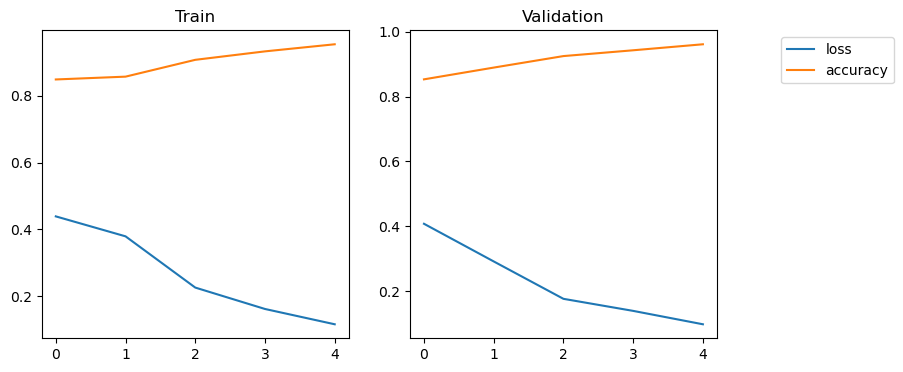

In [11]:
loss_history = history.history

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].set_title('Train')
ax[0].plot(loss_history['loss'], label='loss')
ax[0].plot(loss_history['binary_accuracy'], label='accuracy')

ax[1].set_title('Validation')
ax[1].plot(loss_history['val_loss'], label='loss')
ax[1].plot(loss_history['val_binary_accuracy'], label='accuracy')

plt.legend(loc='upper right', bbox_to_anchor=(1.6, 1.0))
plt.subplots_adjust(right=0.8)
plt.show();

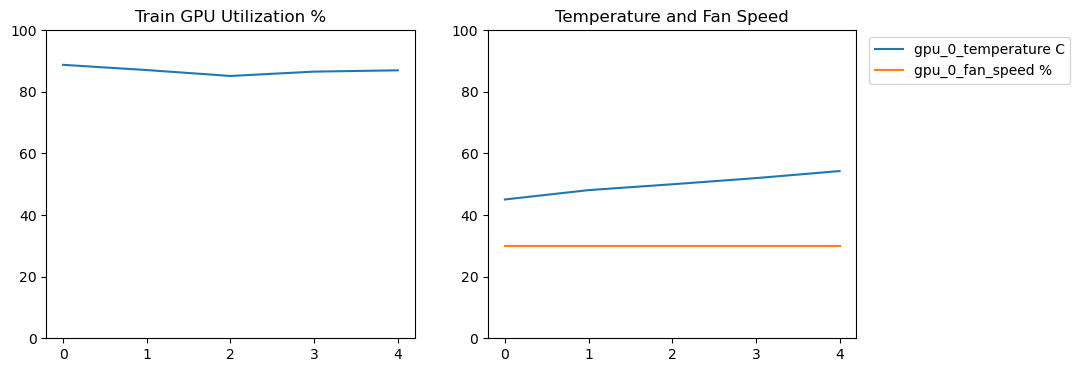

In [13]:
loss_history = history.history

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].set_title('Train GPU Utilization %')
ax[0].plot(loss_history['gpu_0_utilization'], label='gpu_0_utilization %')
ax[0].set_ylim(0, 100)

ax[1].set_title('Temperature and Fan Speed')
ax[1].plot(loss_history['gpu_0_temperature'], label='gpu_0_temperature C')
ax[1].plot(loss_history['gpu_0_fan_speed'], label='gpu_0_fan_speed %')
ax[1].set_ylim(0, 100)

plt.legend(loc='upper right', bbox_to_anchor=(1.6, 1.0))
plt.subplots_adjust(right=0.8)
plt.show();